# Functional/Verb-base Data Manipulation

`utilz.dfverbs` provides a module that offers [dplyr](https://dplyr.tidyverse.org/)-like functionality on top of pandas dataframes. The convention is to import it as an alias: `import utilz.dfverbs as _`. In recent versions of the ipython kernel, `_` isn't overwritten with recent interaction evaluations so its safe to use this alias. 

Most pandas methods are accessible and function exactly like calling them directly on a dataframe, i.e.

    _.head() == df.head()

However there are additional functions that mimic behavior from the tidyverse. These include:
- `_.query()` for filtering/selecting rows based on their values\*
- `_.sort()` for re-ordering rows
- `_.select()` for picking columns by name
- `_.mutate()` for creating new columns from existing columns with functions
    - `_.transmute()` just like mutate but only returns the new columns
- `_.summarize()` for collapsing many values down to single summary
- `_.groupby` for splitting data into sub-datasets

\**`_.query` is the only function differs in its behavior even though it has the same name as `df.query`. It supports everything `df.query` does **and** `df.loc`. That means you can pass in a (1) query string, (2) boolean array/series (3) index (4) callable function that accepts the entire dataframe as an argument*

In [1]:
from utilz import pipe, tweak
import utilz.dfverbs as _

df = _.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/raw/mpg.csv')

pipe(
    df,
    _.head(),
    # pipe both returns AND shows output by default, since we're not assigning the
    # output of pipe to another variable we don't need to show it as well
    show = False
)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


We can do all the fun data manipulation stuff that `R` folks can like easily creating and extracting new columns. `utilz` always returns dataframes for consistency even if the output contains a single column:

In [2]:
out = pipe(
    df,
    _.groupby('cylinders'),
    _.transmute(displacement_centered_by_cylinders='displacement - displacement.mean()')
    
)

,displacement_centered_by_cylinders
0,-38.009709
1,4.990291
2,-27.009709
3,-41.009709
4,-43.009709
...,...
393,30.203431
394,-12.796569
395,25.203431
396,10.203431


Here's a fun one: Plotting the relationship between a car's weight and average acceleration and stratifying on whether the car was made before or after 1976:

,model_year,avg_accel,avg_weight
0,early,12.948276,3372.793103
1,early,15.142857,2995.428571
2,early,15.125000,3237.714286
3,early,14.312500,3419.025000
4,early,16.203704,2877.925926
5,early,16.050000,3176.800000
6,late,15.941176,3078.735294
7,late,15.435714,2997.357143
8,late,15.805556,2861.805556
9,late,15.813793,3055.344828


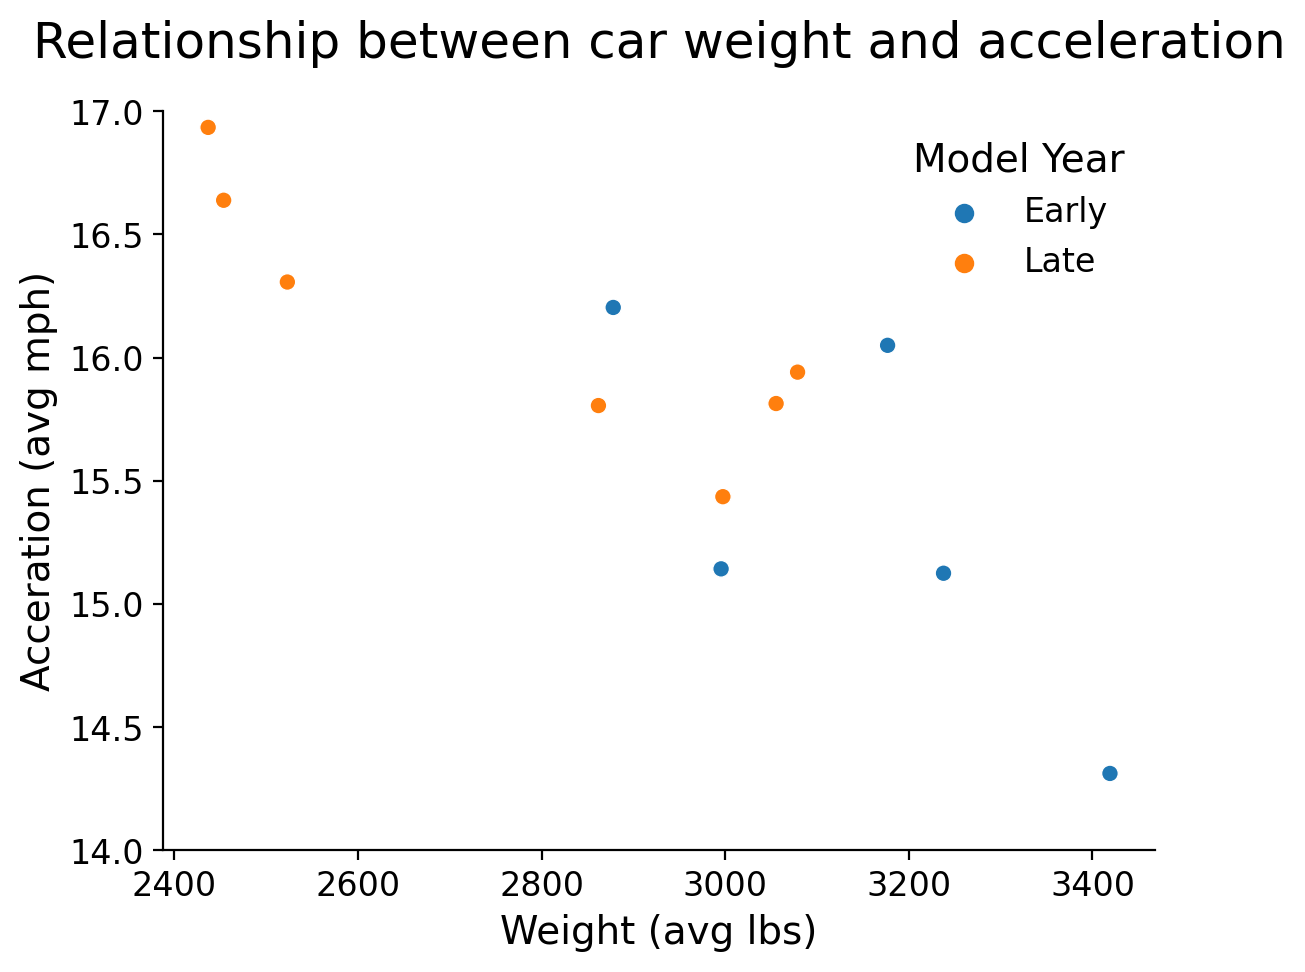

In [4]:
out = pipe(
    df,
    _.groupby("model_year"),
    _.summarize(avg_accel="acceleration.mean()", avg_weight="weight.mean()"),
    _.mutate(
        model_year=lambda model_year: model_year.apply(
            lambda year: "early" if year < 76 else "late"
        )
    ),
    _.scatterplot(x="avg_weight", y="avg_accel", hue="model_year"),
    # Swiss army knife plot tweaking function
    tweak(
        despine=True,
        title="Relationship between car weight and acceleration",
        ylabel = 'Acceration (avg mph)',
        xlabel = 'Weight (avg lbs)',
        ylim=(14.0, 17.0),
        legend_title='Model Year',
        legend_frame=False,
        legend_labels=['Early', 'Late'],
        title_fontsize = 18,
        legend_title_fontsize = 14,
        xlabel_fontsize= 14,
        ylabel_fontsize= 14,
        xticklabel_fontsize=12,
        yticklabel_fontsize=12,
        title_y=1.05,
        legend_labels_fontsize=12,
    ),
    show=True,
)